In [99]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
from PIL import Image
from math import *
import seaborn as sns # visualization
%matplotlib inline
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression

In [56]:
Telecom= pd.read_csv("churn-bigml-80.csv")
Telecom_test= pd.read_csv("churn-bigml-20.csv")
Telecom.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

### Data Overview

In [57]:
def dataoverview (df, message):
    print(f'\n {message}')
    print('\n Total no of rows/observation are:', df.shape[0])
    print('\n Total no of columns/features are:', df.shape[1])
    print('\n Features:')
    print(df.columns.to_list())
    print("\n Missing values:\n",df.isnull().sum().sum())
    print("\n Unique values:\n",df.nunique())
    print("\n Vaiable info:\n",df.info())
    print("\n Vaiable Correlation\n",df.corr())

In [58]:
dataoverview (Telecom, "train_data_overview")


 train_data_overview

 Total no of rows/observation are: 2666

 Total no of columns/features are: 20

 Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

 Missing values:
 0

 Unique values:
 State                       51
Account length             205
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       42
Total day minutes         1489
Total day calls            115
Total day charge          1489
Total eve minutes         1442
Total eve calls            120
Total eve charge          1301
Total night minutes       1444
Total night calls          118
Total night charge    

In [59]:
dataoverview (Telecom_test, "Test dataset overview")


 Test dataset overview

 Total no of rows/observation are: 667

 Total no of columns/features are: 20

 Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

 Missing values:
 0

 Unique values:
 State                      51
Account length            179
Area code                   3
International plan          2
Voice mail plan             2
Number vmail messages      37
Total day minutes         562
Total day calls           100
Total day charge          562
Total eve minutes         557
Total eve calls            94
Total eve charge          528
Total night minutes       568
Total night calls          96
Total night charge        453
Total

### Exploratry Data Analysis:

<AxesSubplot:>

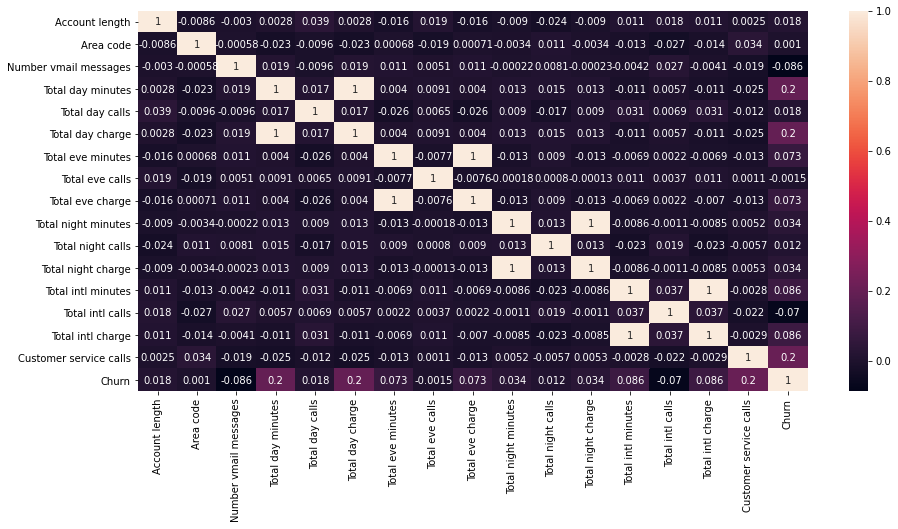

In [60]:
plt.figure (figsize= (15,7))
sns.heatmap(Telecom.corr(), annot = True)

In [61]:
Telecom['Churn'].value_counts()

False    2278
True      388
Name: Churn, dtype: int64

In [62]:
percentage_True_churn= (388/(2278+388))*100
percentage_True_churn

14.553638409602401

##### Here Dependent variable is having 85:15 ratio of the both categories, so it looks imbalance dataset. We will use SMOTE for its treatment.

In [63]:
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization

In [64]:
trace = go.Pie(labels = Telecom["Churn"].value_counts().keys().tolist(),
               values = Telecom["Churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'], line = dict(color = "white", width =  1.3)), rotation = 90,
               hoverinfo = "label+value+text", hole = .5)
layout = go.Layout(dict(title = "Customer churn in training data", plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",))
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

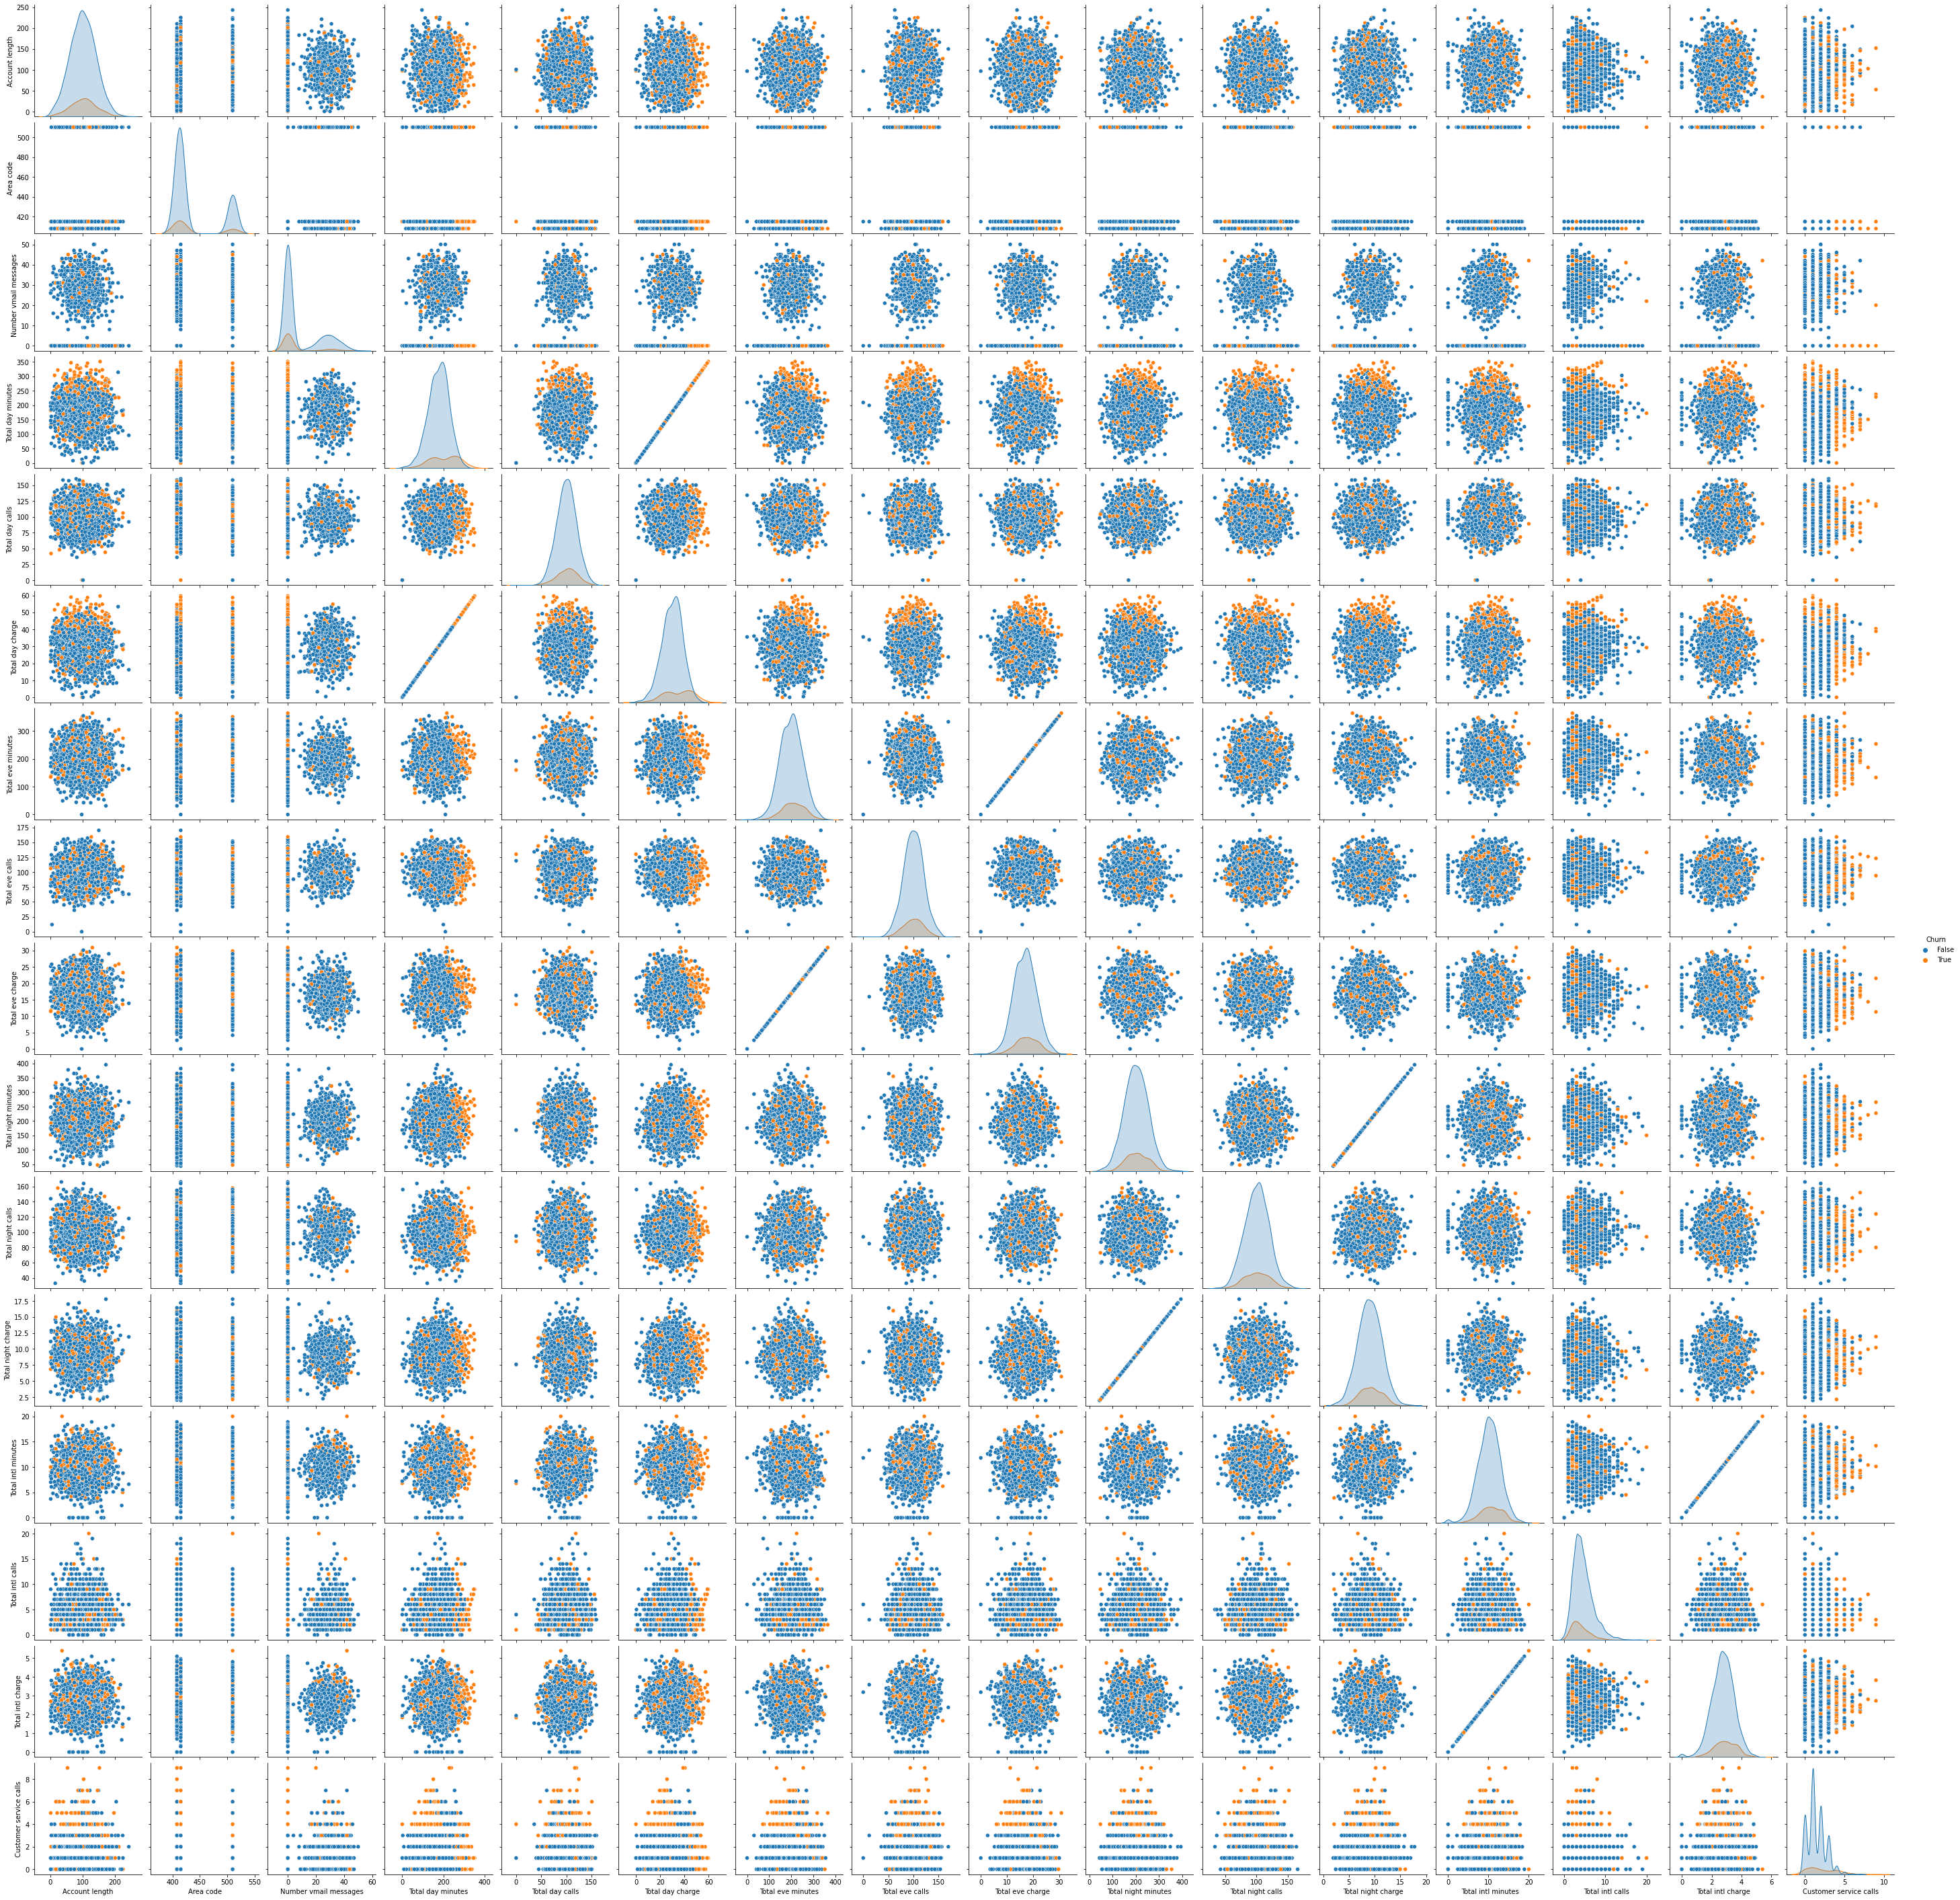

In [65]:
sns_plot= sns.pairplot(data = Telecom, hue= 'Churn', height= 2.5, aspect = 1)
sns_plot.savefig("Pair plots.png")

#### As per shown distribution , logistic regression will not best fit for this, we have to check with other classifiaction algos also.

## Data Preprocessing

In [66]:
#Removing correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 
               'Total night charge', 'Total intl charge']
   
Telecom = Telecom.drop(columns = col_to_drop, axis = 1)
Telecom_test = Telecom_test.drop(columns = col_to_drop, axis = 1)

In [67]:
Telecom_test.shape

(667, 14)

In [68]:
Telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          2666 non-null   int64  
 1   International plan      2666 non-null   object 
 2   Voice mail plan         2666 non-null   object 
 3   Number vmail messages   2666 non-null   int64  
 4   Total day minutes       2666 non-null   float64
 5   Total day calls         2666 non-null   int64  
 6   Total eve minutes       2666 non-null   float64
 7   Total eve calls         2666 non-null   int64  
 8   Total night minutes     2666 non-null   float64
 9   Total night calls       2666 non-null   int64  
 10  Total intl minutes      2666 non-null   float64
 11  Total intl calls        2666 non-null   int64  
 12  Customer service calls  2666 non-null   int64  
 13  Churn                   2666 non-null   bool   
dtypes: bool(1), float64(4), int64(7), object

In [69]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [70]:
Telecom.shape

(2666, 14)

In [71]:
Telecom.describe(include= 'all')

Account length International plan Voice mail plan  \
count      2666.000000               2666            2666   
unique             NaN                  2               2   
top                NaN                 No              No   
freq               NaN               2396            1933   
mean        100.620405                NaN             NaN   
std          39.563974                NaN             NaN   
min           1.000000                NaN             NaN   
25%          73.000000                NaN             NaN   
50%         100.000000                NaN             NaN   
75%         127.000000                NaN             NaN   
max         243.000000                NaN             NaN   

        Number vmail messages  Total day minutes  Total day calls  \
count             2666.000000         2666.00000      2666.000000   
unique                    NaN                NaN              NaN   
top                       NaN                NaN              NaN   
freq                      NaN                NaN              NaN   
mean                 8.021755          179.48162       100.310203   
std                 13.612277           54.21035        19.988162   
min                  0.000000            0.00000         0.000000   
25%                  0.000000          143.40000        87.000000   
50%                  0.000000          179.95000       101.000000   
75%                 19.000000          215.90000       114.000000   
max                 50.000000          350.80000       160.000000   

        Total eve minutes  Total eve calls  Total night minutes  \
count         2666.000000      2666.000000          2666.000000   
unique                NaN              NaN                  NaN   
top                   NaN              NaN                  NaN   
freq                  NaN              NaN                  NaN   
mean           200.386159       100.023631           201.168942   
std             50.951515        20.161445            50.780323   
min              0.000000         0.000000            43.700000   
25%            165.300000        87.000000           166.925000   
50%            200.900000       100.000000           201.150000   
75%            235.100000       114.000000           236.475000   
max            363.700000       170.000000           395.000000   

        Total night calls  Total intl minutes  Total intl calls  \
count         2666.000000         2666.000000       2666.000000   
unique                NaN                 NaN               NaN   
top                   NaN                 NaN               NaN   
freq                  NaN                 NaN               NaN   
mean           100.106152           10.237022          4.467367   
std             19.418459            2.788349          2.456195   
min             33.000000            0.000000          0.000000   
25%             87.000000            8.500000          3.000000   
50%            100.000000           10.200000          4.000000   
75%            113.000000           12.100000          6.000000   
max            166.000000           20.000000         20.000000   

        Customer service calls  Churn  
count              2666.000000   2666  
unique                     NaN      2  
top                        NaN  False  
freq                       NaN   2278  
mean                  1.562641    NaN  
std                   1.311236    NaN  
min                   0.000000    NaN  
25%                   1.000000    NaN  
50%                   1.000000    NaN  
75%                   2.000000    NaN  
max                   9.000000    NaN

In [72]:
Telecom.head()

Account length International plan Voice mail plan  Number vmail messages  \
0             128                 No             Yes                     25   
1             107                 No             Yes                     26   
2             137                 No              No                      0   
3              84                Yes              No                      0   
4              75                Yes              No                      0   

   Total day minutes  Total day calls  Total eve minutes  Total eve calls  \
0              265.1              110              197.4               99   
1              161.6              123              195.5              103   
2              243.4              114              121.2              110   
3              299.4               71               61.9               88   
4              166.7              113              148.3              122   

   Total night minutes  Total night calls  Total intl minutes  \
0                244.7                 91                10.0   
1                254.4                103                13.7   
2                162.6                104                12.2   
3                196.9                 89                 6.6   
4                186.9                121                10.1   

   Total intl calls  Customer service calls  Churn  
0                 3                       1  False  
1                 3                       1  False  
2                 5                       0  False  
3                 7                       2  False  
4                 3                       3  False

In [73]:
Telecom_test.describe(include= 'all')

Account length International plan Voice mail plan  \
count       667.000000                667             667   
unique             NaN                  2               2   
top                NaN                 No              No   
freq               NaN                614             478   
mean        102.841079                NaN             NaN   
std          40.819480                NaN             NaN   
min           1.000000                NaN             NaN   
25%          76.000000                NaN             NaN   
50%         102.000000                NaN             NaN   
75%         128.000000                NaN             NaN   
max         232.000000                NaN             NaN   

        Number vmail messages  Total day minutes  Total day calls  \
count              667.000000         667.000000       667.000000   
unique                    NaN                NaN              NaN   
top                       NaN                NaN              NaN   
freq                      NaN                NaN              NaN   
mean                 8.407796         180.948126       100.937031   
std                 13.994480          55.508628        20.396790   
min                  0.000000          25.900000        30.000000   
25%                  0.000000         146.250000        87.500000   
50%                  0.000000         178.300000       101.000000   
75%                 20.000000         220.700000       115.000000   
max                 51.000000         334.300000       165.000000   

        Total eve minutes  Total eve calls  Total night minutes  \
count          667.000000       667.000000           667.000000   
unique                NaN              NaN                  NaN   
top                   NaN              NaN                  NaN   
freq                  NaN              NaN                  NaN   
mean           203.355322       100.476762           199.685307   
std             49.719268        18.948262            49.759931   
min             48.100000        37.000000            23.200000   
25%            171.050000        88.000000           167.950000   
50%            203.700000       101.000000           201.600000   
75%            236.450000       113.000000           231.500000   
max            361.800000       168.000000           367.700000   

        Total night calls  Total intl minutes  Total intl calls  \
count          667.000000          667.000000        667.000000   
unique                NaN                 NaN               NaN   
top                   NaN                 NaN               NaN   
freq                  NaN                 NaN               NaN   
mean           100.113943           10.238381          4.527736   
std             20.172505            2.807850          2.482442   
min             42.000000            0.000000          0.000000   
25%             86.000000            8.600000          3.000000   
50%            100.000000           10.500000          4.000000   
75%            113.500000           12.050000          6.000000   
max            175.000000           18.300000         18.000000   

        Customer service calls  Churn  
count               667.000000    667  
unique                     NaN      2  
top                        NaN  False  
freq                       NaN    572  
mean                  1.563718    NaN  
std                   1.333357    NaN  
min                   0.000000    NaN  
25%                   1.000000    NaN  
50%                   1.000000    NaN  
75%                   2.000000    NaN  
max                   8.000000    NaN

### Dividing the datasets into dependent & Independent features

In [75]:
X_train= Telecom.drop(['Churn'], axis=1)
Y_train= Telecom['Churn']
X_test= Telecom_test.drop(['Churn'], axis=1)
Y_test= Telecom_test['Churn']

In [76]:
Y_train.head()

0    False
1    False
2    False
3    False
4    False
Name: Churn, dtype: bool

### Converting the categorical features

In [82]:
X_train1= pd.get_dummies(data=X_train, columns= ['International plan',"Voice mail plan"], drop_first=True)

In [83]:
X_train1.head()

Account length  Number vmail messages  Total day minutes  Total day calls  \
0             128                     25              265.1              110   
1             107                     26              161.6              123   
2             137                      0              243.4              114   
3              84                      0              299.4               71   
4              75                      0              166.7              113   

   Total eve minutes  Total eve calls  Total night minutes  Total night calls  \
0              197.4               99                244.7                 91   
1              195.5              103                254.4                103   
2              121.2              110                162.6                104   
3               61.9               88                196.9                 89   
4              148.3              122                186.9                121   

   Total intl minutes  Total intl calls  Customer service calls  \
0                10.0                 3                       1   
1                13.7                 3                       1   
2                12.2                 5                       0   
3                 6.6                 7                       2   
4                10.1                 3                       3   

   International plan_Yes  Voice mail plan_Yes  
0                       0                    1  
1                       0                    1  
2                       0                    0  
3                       1                    0  
4                       1                    0

In [84]:
X_test1= pd.get_dummies(data=X_test, columns= ['International plan',"Voice mail plan"], drop_first=True)

In [85]:
Y_train1 = Y_train.replace({False:0, True:1})

In [86]:
Y_test1 = Y_test.replace({False:0, True:1})

In [108]:
cols = X_train1.columns

### Feature scalling / standardization

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

In [91]:
#convert to dataframe again
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [92]:
X_train_scaled.head()

0         1         2         3         4         5         6   \
0  0.692163  1.247508  1.579670  0.484868 -0.058619 -0.050781  0.857403   
1  0.161278  1.320985 -0.329918  1.135375 -0.095916  0.147654  1.048458   
2  0.919686 -0.589414  1.179302  0.685024 -1.554439  0.494917 -0.759668   
3 -0.420168 -0.589414  2.212509 -1.466653 -2.718509 -0.596479 -0.084083   
4 -0.647691 -0.589414 -0.235822  0.634985 -1.022461  1.090224 -0.281046   

         7         8         9         10        11        12  
0 -0.469031 -0.085020 -0.597527 -0.429172 -0.335690  1.623917  
1  0.149054  1.242179 -0.597527 -0.429172 -0.335690  1.623917  
2  0.200561  0.704125  0.216894 -1.191955 -0.335690 -0.615795  
3 -0.572045 -1.304609  1.031314  0.333610  2.978938 -0.615795  
4  1.076181 -0.049150 -0.597527  1.096392  2.978938 -0.615795

### Applying the SMOTE technique to balance the dataset

In [95]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors= 5, sampling_strategy=0.7)
X_smot, Y_smot = sm.fit_sample(X_train_scaled, Y_train1)

### Model Building

In [97]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    return

In [98]:
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return

In [100]:
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    dec_tree = tree.DecisionTreeClassifier(min_samples_split=10,
                                           min_samples_leaf=5).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = dec_tree.predict(X_test)

    # Export visualization as file
    #visualize_tree(dec_tree,X_train,y_train)
    
    # Get Cross Validation and Confusion matrix
    get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    get_roc(y_test, y_pred)    
    
    return

clean resampled
Cross Validation Accuracy: 0.90 (+/- 0.02)
Cross Validation Precision: 0.89 (+/- 0.02)
Cross Validation roc_auc: 0.94 (+/- 0.02)
[[538  34]
 [ 24  71]]


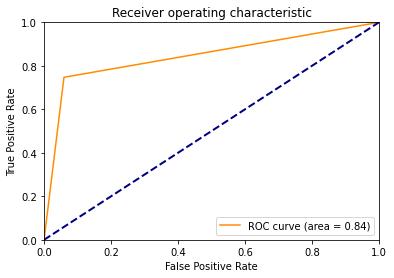

In [101]:
# Decisiontree
# Train, test and evaluate the classifiers with different preprocessed data
print("clean resampled")
dectreeclf(X_smot, Y_smot, X_test_scaled,Y_test1)

In [111]:
# fit, train and cross validate Decision Tree with training and test data 
def randomforestclf(X_train, y_train,X_test, y_test):
    print("RandomForestClassifier")
    randomforest = RandomForestClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = randomforest.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(randomforest, X_train, y_train,y_test,y_pred)
    get_roc(y_test, y_pred)
    return

In [112]:
def knnclf(X_train, y_train, X_test, y_test):  
    print("KNeighborsClassifier")
    knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = knn.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(knn, X_train, y_train,y_test,y_pred)
    get_roc(y_test, y_pred) 
    return

In [113]:
# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    get_roc(y_test, y_pred)
    return

clean resampled
RandomForestClassifier
Cross Validation Accuracy: 0.96 (+/- 0.02)
Cross Validation Precision: 0.96 (+/- 0.01)
Cross Validation roc_auc: 0.99 (+/- 0.01)
[[553  19]
 [ 19  76]]


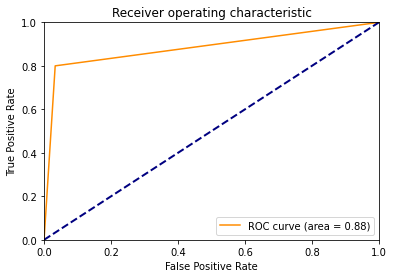

In [114]:
# Random forest
print("clean resampled")
randomforestclf(X_smot, Y_smot, X_test_scaled,Y_test1)

clean resampled
KNeighborsClassifier
Cross Validation Accuracy: 0.91 (+/- 0.01)
Cross Validation Precision: 0.83 (+/- 0.02)
Cross Validation roc_auc: 0.96 (+/- 0.01)
[[486  86]
 [ 37  58]]


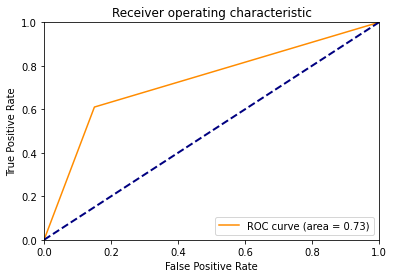

In [115]:
# KNN
print("clean resampled")
knnclf(X_smot, Y_smot, X_test_scaled,Y_test1)

clean resampled
LogisticRegression
Cross Validation Accuracy: 0.77 (+/- 0.03)
Cross Validation Precision: 0.75 (+/- 0.04)
Cross Validation roc_auc: 0.84 (+/- 0.03)
[[477  95]
 [ 33  62]]


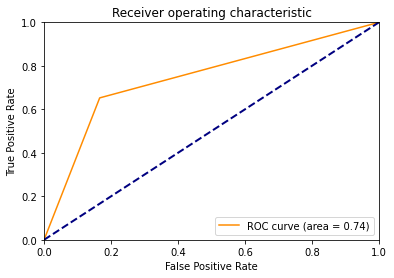

In [116]:
# Logistic regression
print("clean resampled")
logregclf(X_smot, Y_smot, X_test_scaled,Y_test1)